# Реализация задания 3

Заголовок со всякими импортами

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

%matplotlib widget
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from IPython.display import display, Math, Latex

# number of terms in solving degree equation
_ELLIPDEG_MMAX = 7


def _ellipdeg(n, m1):
    """Solve degree equation using nomes

    Given n, m1, solve
       n * K(m) / K'(m) = K1(m1) / K1'(m1)
    for m
    
    NB: Uses squares of arguments!
    See [1], Eq. (49)
    
    References
    ----------
    .. [1] Orfanidis, "Lecture Notes on Elliptic Filter Design",
           https://www.ece.rutgers.edu/~orfanidi/ece521/notes.pdf
    """
    K1 = sp.special.ellipk(m1)
    K1p = sp.special.ellipkm1(m1)

    q1 = np.exp(-np.pi * K1p / K1)
    q = q1 ** (1/n)

    mnum = np.arange(_ELLIPDEG_MMAX + 1)
    mden = np.arange(1, _ELLIPDEG_MMAX + 2)

    num = np.sum(q ** (mnum * (mnum+1)))
    den = 1 + 2 * np.sum(q ** (mden**2))

    return 16 * q * (num / den) ** 4

## 1. Общее представление
Для "игр" с типами фильтров. Параметры такие:
* `order` — порядок фильтра
* `rp` — неравномерность (в дБ) для полосы пропускания (относится к фильтрам Чебышева и эллиптическим)
* `rn` — максимальный уровень (в дБ) в полосе задержания (для эллиптического фильтра)

interactive(children=(Dropdown(description='filter', options=(('Butterworth', <function buttap at 0x7fa6ec05a1…

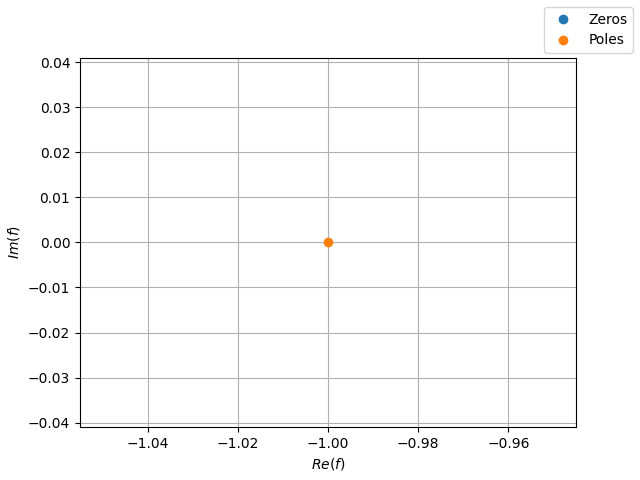

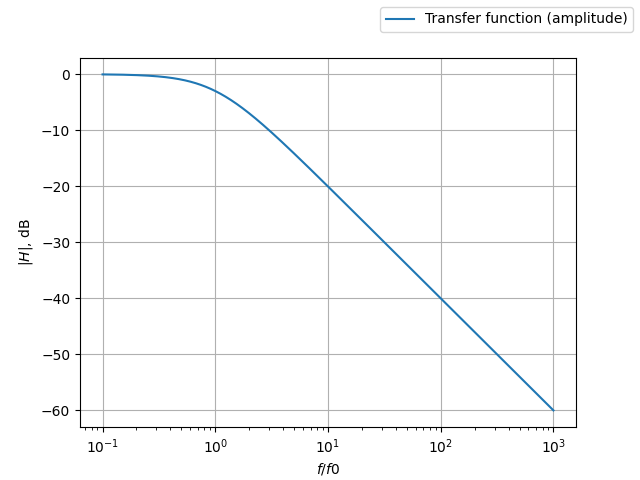

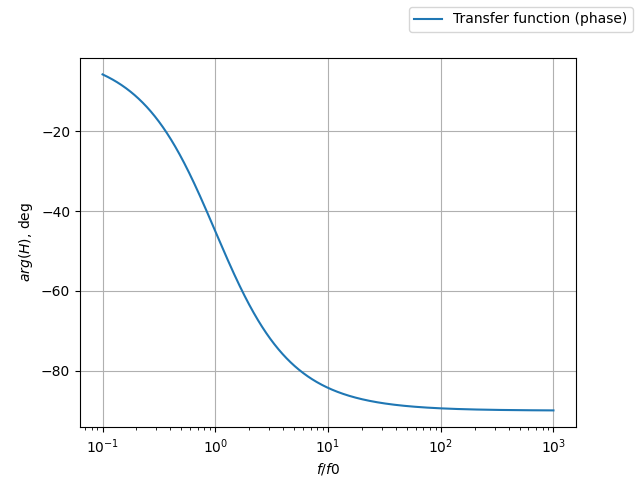

In [2]:
def task1_1():
    fig_zp, ax_zp = plt.subplots()
    fig_amp, ax_amp = plt.subplots()
    fig_ph, ax_ph = plt.subplots()
    @interact(
        filter = widgets.Dropdown(options = [
            ("Butterworth", sp.signal.buttap),
            ("Chebyshev", sp.signal.cheb1ap),
            ("Elliptic", sp.signal.ellipap)]),
        order = widgets.IntSlider(min = 1, max = 13, step = 1, value = 1),
        rp = widgets.FloatSlider(min = 1, max = 10, step = 0.1, value = 3),
        rs = widgets.FloatSlider(min = 20, max = 100, step = 0.1, value = 40)
    )         
    def myplot(filter, order, rp, rs):
        if filter == sp.signal.buttap:
            opts = {"N": order}
        elif filter == sp.signal.cheb1ap:
            opts = {"N": order, "rp": rp}
        elif filter == sp.signal.ellipap:
            opts = {"N": order, "rp": rp, "rs": rs}
        z, p, k = filter(**opts)
        w, h = sp.signal.freqs_zpk(z, p, k, worN = np.logspace(-1, 3, 1001))
        
        ax_zp.cla()
        ax_zp.axis("equal")
        ax_zp.grid(True)
        ax_zp.plot(z.real, z.imag, "o", label = "Zeros")
        ax_zp.plot(p.real, p.imag, "o", label = "Poles")
        fig_zp.legend()
        ax_zp.set_xlabel("$Re(f)$")
        ax_zp.set_ylabel("$Im(f)$")
    
        ax_amp.cla()
        ax_amp.grid(True)
        ax_amp.semilogx(w, 20*np.log10(np.abs(h)), label = "Transfer function (amplitude)")
        fig_amp.legend()
        ax_amp.set_xlabel("$f/f0$")
        ax_amp.set_ylabel("$|H|$, dB")
        
        ax_ph.cla()
        ax_ph.grid(True)
        ax_ph.semilogx(w, np.unwrap(np.angle(h, deg = True), period=180), label = "Transfer function (phase)")
        fig_ph.legend()
        ax_ph.set_xlabel("$f/f0$")
        ax_ph.set_ylabel("$arg(H)$, deg")

task1_1()

## 2. Сравнение Чебышева и Баттерворта (при одном уровне)

Fading for Chebyshev at Wn = 2.0: -74.0 dB
Frequency for Butterworth(N = 7): 3.38


interactive(children=(Checkbox(value=True, description='Line2D(Chebyshev (N = 7, rp = 3 dB))'), Checkbox(value…

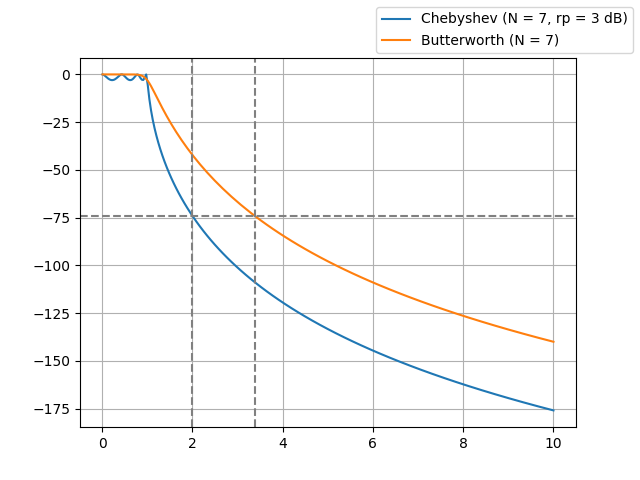

In [3]:
def task2_1():
    w, h = sp.signal.freqs_zpk(*sp.signal.cheb1ap(N = 7, rp = 3.0), worN = 2.0)
    Eta = 10**(1/(2*7) * np.log10(1/np.abs(h[0])**2 - 1))
    # w, h = sp.signal.freqs_zpk(*sp.signal.buttap(N = 7), worN = Eta)
    print(f"Fading for Chebyshev at Wn = 2.0: {20*np.log10(np.abs(h[0])):4.1f} dB")
    print(f"Frequency for Butterworth(N = 7): {Eta:4.2f}")
    
    w1, h1 = sp.signal.freqs_zpk(*sp.signal.cheb1ap(N = 7, rp = 3.0))
    w2, h2 = sp.signal.freqs_zpk(*sp.signal.buttap(N = 7))
    
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.plot(w1, 20*np.log10(np.abs(h1)), label = "Chebyshev (N = 7, rp = 3 dB)")
    ax.plot(w2, 20*np.log10(np.abs(h2)), label = "Butterworth (N = 7)")
    ax.axvline(2.0, linestyle = '--', color = "gray")
    ax.axhline(20*np.log10(np.abs(h[0])), linestyle = '--', color = "gray")
    ax.axvline(Eta, linestyle = '--', color = "gray")
    fig.legend()
    @interact(
        l0 = widgets.Checkbox(value = True, description = str(ax.lines[0])),
        l1 = widgets.Checkbox(value = True, description = str(ax.lines[1])))
    def update(l0, l1):
        ax.lines[0].set_ls("-" if l0 else "None")
        ax.lines[1].set_ls("-" if l1 else "None")
task2_1()

## 3. Сравнение Чебышева и Баттерворта (при одной частоте)

Fading for Chebyshev at Wn = 1.5: -52.5 dB
Order of Butterworth: 15


interactive(children=(Checkbox(value=True, description='Line2D(Chebyshev (N = 7, rp = 3 dB))'), Checkbox(value…

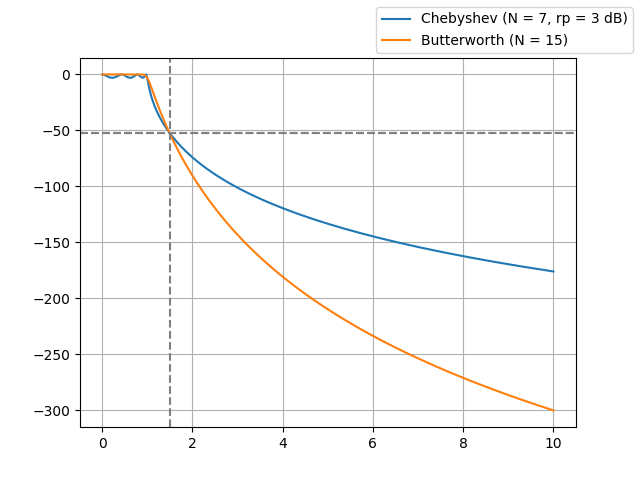

In [4]:
def task3_1():
    worN = 1.5
    w, h = sp.signal.freqs_zpk(*sp.signal.cheb1ap(N = 7, rp = 3.0), worN = worN)
    buttN = int(np.round(0.5*np.log10(1/np.abs(h[0])**2 - 1)/np.log10(worN)))
    print(f"Fading for Chebyshev at Wn = 1.5: {20*np.log10(np.abs(h[0])):4.1f} dB")
    print(f"Order of Butterworth: {buttN}")
    
    w1, h1 = sp.signal.freqs_zpk(*sp.signal.cheb1ap(N = 7, rp = 3.0))
    w2, h2 = sp.signal.freqs_zpk(*sp.signal.buttap(N = buttN))
    
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.plot(w1, 20*np.log10(np.abs(h1)), label = "Chebyshev (N = 7, rp = 3 dB)"),
    ax.plot(w2, 20*np.log10(np.abs(h2)), label = f"Butterworth (N = {buttN})"),    
    ax.axvline(worN, linestyle = "--", color = "gray")
    ax.axhline(20*np.log10(np.abs(h[0])), linestyle = "--", color = "gray")
    ax.axhline(20*np.log10(np.abs(h[0])), linestyle = '--', color = "gray")
    fig.legend()
    @interact(
        l0 = widgets.Checkbox(value = True, description = str(ax.lines[0])),
        l1 = widgets.Checkbox(value = True, description = str(ax.lines[1])))
    def update(l0, l1):
        ax.lines[0].set_ls("-" if l0 else "None")
        ax.lines[1].set_ls("-" if l1 else "None")

task3_1()

## 4. Сравнение эллиптического и Чебышева (при одном уровне)

Решение уравнения ($\eta$ — граничная частота, $\eta_1$ — минимальное ослабление в зоне затухания)
$$R_n(\eta) = \eta_1$$

In [5]:
def ellip_stopband_level(N, eta):
    """ Ослабление эллиптического фильтра в дБ
    """
    return 10*np.log10(1-_ellipdeg(N, 1-1/eta**2))
def ellip_stopband_freq(N, eta1):
    """ Граничная частота эллиптического фильтра с заданным уровнем
    """
    return 1/np.sqrt(_ellipdeg(7, 10**(-0.1*eta1)))

Уровень затухания эллиптического фильтра 7-го порядка с граничной частотой 1.1

In [6]:
rs = -ellip_stopband_level(7, 1.1)
print(f"Fade level = {rs:4.2f} dB")

Fade level = 55.68 dB


По сравнению с Чебышевым того же порядка:

Fading for elliptical at Wn = 1.1: -55.7 dB
Frequency for Chebyshev: 1.56


interactive(children=(Checkbox(value=True, description='Line2D(Elliptic)'), Checkbox(value=True, description='…

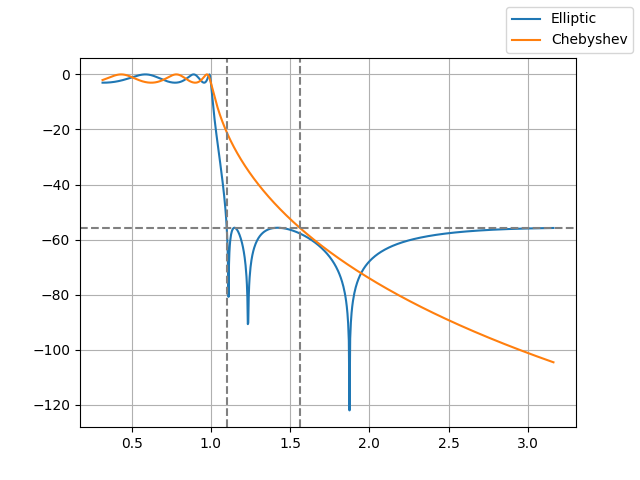

In [7]:
def task4_1():
    rp = 10*np.log10(2)
    worN = 1.1
    w, h = sp.signal.freqs_zpk(*sp.signal.ellipap(N = 7, rp = rp, rs = rs), worN = worN)
    # Eta = 10**(1/(2*7) * np.log10(1/np.abs(h[0])**2 - 1))
    # w, h = sp.signal.freqs_zpk(*sp.signal.buttap(N = 7), worN = Eta)
    print(f"Fading for elliptical at Wn = {worN}: {20*np.log10(np.abs(h[0])):4.1f} dB")
    
    freqs = np.logspace(-0.5, 0.5, 1001)
    w1, h1 = sp.signal.freqs_zpk(*sp.signal.ellipap(N = 7, rp = rp, rs = rs), worN = freqs)
    w2, h2 = sp.signal.freqs_zpk(*sp.signal.cheb1ap(N = 7, rp = rp), worN = freqs)
    cheb_filter = sp.interpolate.interp1d(w2, rs + 20*np.log10(np.abs(h2)))
    chebWorN = sp.optimize.fsolve(cheb_filter, worN)[0]
    print(f"Frequency for Chebyshev: {chebWorN:4.2f}")
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.plot(w1, 20*np.log10(np.abs(h1)), label = "Elliptic")
    ax.plot(w2, 20*np.log10(np.abs(h2)), label = "Chebyshev")
    kw = {"linestyle": "--", "color": "gray"}
    ax.axvline(worN, **kw)
    ax.axhline(-rs, **kw)
    ax.axvline(chebWorN, **kw)
    fig.legend()
    @interact(
        l0 = widgets.Checkbox(value = True, description = str(ax.lines[0])),
        l1 = widgets.Checkbox(value = True, description = str(ax.lines[1])))
    def update(l0, l1):
        ax.lines[0].set_ls("-" if l0 else "None")
        ax.lines[1].set_ls("-" if l1 else "None")

task4_1()

## 5. Преобразования фильтров Баттерворта и Чебышева

Для фильтра Баттерворта 7-го порядка преобразование в highpass и bandpass:

interactive(children=(Checkbox(value=True, description='Line2D(Lowpass)'), Checkbox(value=True, description='L…

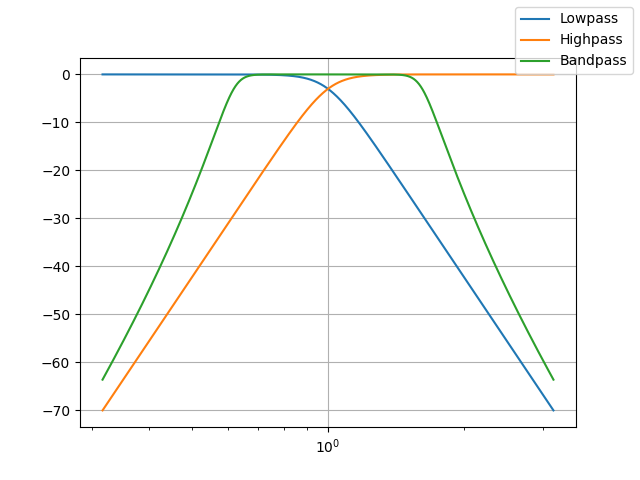

In [8]:
def task5_1():
    freqs = np.logspace(-0.5, 0.5, 1001)
    zpk = sp.signal.buttap(N = 7)
    w1, h1 = sp.signal.freqs_zpk(*zpk, worN = freqs)
    w2, h2 = sp.signal.freqs_zpk(*sp.signal.lp2hp_zpk(*zpk), worN = freqs)
    w3, h3 = sp.signal.freqs_zpk(*sp.signal.lp2bp_zpk(*zpk, 1), worN = freqs)
    fig, ax = plt.subplots()
    ax.grid(True)
    lp = ax.semilogx(w1, 20*np.log10(np.abs(h1)), label = "Lowpass")
    hp = ax.semilogx(w2, 20*np.log10(np.abs(h2)), label = "Highpass")
    bp = ax.semilogx(w3, 20*np.log10(np.abs(h3)), label = "Bandpass")
    fig.legend()
    @interact(
        l0 = widgets.Checkbox(value = True, description = str(ax.lines[0])),
        l1 = widgets.Checkbox(value = True, description = str(ax.lines[1])),
        l2 = widgets.Checkbox(value = True, description = str(ax.lines[2])))
    def update(l0, l1, l2):
        ax.lines[0].set_ls("-" if l0 else "None")
        ax.lines[1].set_ls("-" if l1 else "None")
        ax.lines[2].set_ls("-" if l2 else "None")

task5_1()

Для разных значений ширины полосы:

interactive(children=(Checkbox(value=True, description='Line2D(Q = 2)'), Checkbox(value=True, description='Lin…

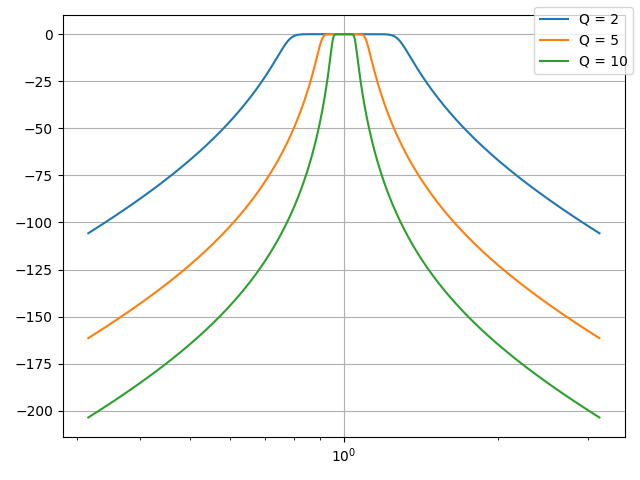

In [9]:
def task5_2():
    freqs = np.logspace(-0.5, 0.5, 1001)
    zpk = sp.signal.buttap(N = 7)
    w1, h1 = sp.signal.freqs_zpk(*sp.signal.lp2bp_zpk(*zpk, bw = 1/2), worN = freqs)
    w2, h2 = sp.signal.freqs_zpk(*sp.signal.lp2bp_zpk(*zpk, bw = 1/5), worN = freqs)
    w3, h3 = sp.signal.freqs_zpk(*sp.signal.lp2bp_zpk(*zpk, bw = 1/10), worN = freqs)
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.semilogx(w1, 20*np.log10(np.abs(h1)), label = "Q = 2")
    ax.semilogx(w2, 20*np.log10(np.abs(h2)), label = "Q = 5")
    ax.semilogx(w3, 20*np.log10(np.abs(h3)), label = "Q = 10")
    fig.legend()
    fig.tight_layout()
    @interact(
        l0 = widgets.Checkbox(value = True, description = str(ax.lines[0])),
        l1 = widgets.Checkbox(value = True, description = str(ax.lines[1])),
        l2 = widgets.Checkbox(value = True, description = str(ax.lines[2])))
    def update(l0, l1, l2):
        ax.lines[0].set_ls("-" if l0 else "None")
        ax.lines[1].set_ls("-" if l1 else "None")
        ax.lines[2].set_ls("-" if l2 else "None")

task5_2()

Аналогично — для фильтра Чебышева порядка $N = 7$ и неравномерностью $\epsilon = 1$

interactive(children=(Checkbox(value=True, description='Line2D(Lowpass)'), Checkbox(value=True, description='L…

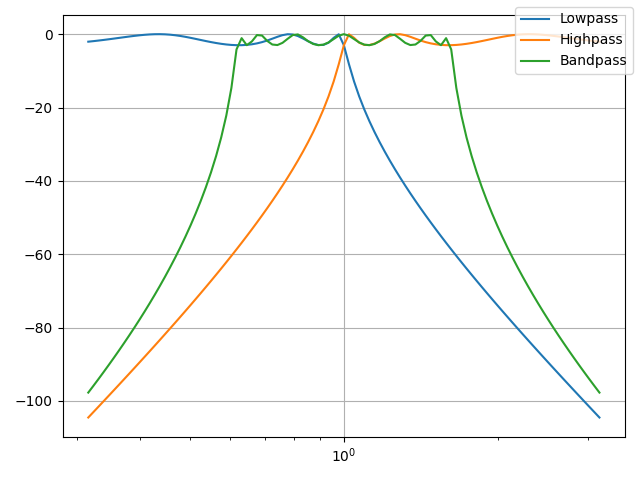

In [10]:
def task5_3():
    freqs = np.logspace(-0.5, 0.5, 101)
    zpk = sp.signal.cheb1ap(N = 7, rp = 10*np.log10(2))
    w1, h1 = sp.signal.freqs_zpk(*zpk, worN = freqs)
    w2, h2 = sp.signal.freqs_zpk(*sp.signal.lp2hp_zpk(*zpk), worN = freqs)
    w3, h3 = sp.signal.freqs_zpk(*sp.signal.lp2bp_zpk(*zpk), worN = freqs)
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.semilogx(w1, 20*np.log10(np.abs(h1)), label = "Lowpass")
    ax.semilogx(w2, 20*np.log10(np.abs(h2)), label = "Highpass")
    ax.semilogx(w3, 20*np.log10(np.abs(h3)), label = "Bandpass")
    fig.legend()
    fig.tight_layout()
    @interact(
        l0 = widgets.Checkbox(value = True, description = str(ax.lines[0])),
        l1 = widgets.Checkbox(value = True, description = str(ax.lines[1])),
        l2 = widgets.Checkbox(value = True, description = str(ax.lines[2])))
    def update(l0, l1, l2):
        ax.lines[0].set_ls("-" if l0 else "None")
        ax.lines[1].set_ls("-" if l1 else "None")
        ax.lines[2].set_ls("-" if l2 else "None")

task5_3()

interactive(children=(Checkbox(value=True, description='Line2D(Q = 2)'), Checkbox(value=True, description='Lin…

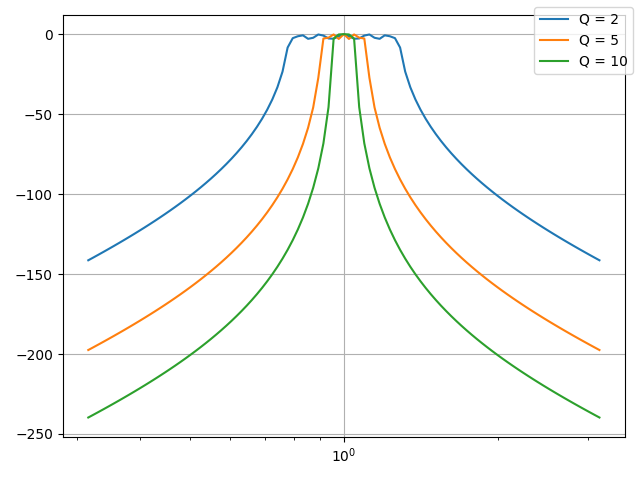

In [11]:
def task5_4():
    freqs = np.logspace(-0.5, 0.5, 101)
    zpk = sp.signal.cheb1ap(N = 7, rp = 10*np.log10(2))
    w1, h1 = sp.signal.freqs_zpk(*sp.signal.lp2bp_zpk(*zpk, bw = 1/2), worN = freqs)
    w2, h2 = sp.signal.freqs_zpk(*sp.signal.lp2bp_zpk(*zpk, bw = 1/5), worN = freqs)
    w3, h3 = sp.signal.freqs_zpk(*sp.signal.lp2bp_zpk(*zpk, bw = 1/10), worN = freqs)
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.semilogx(w1, 20*np.log10(np.abs(h1)), label = "Q = 2")
    ax.semilogx(w2, 20*np.log10(np.abs(h2)), label = "Q = 5")
    ax.semilogx(w3, 20*np.log10(np.abs(h3)), label = "Q = 10")
    fig.legend()
    fig.tight_layout()
    @interact(
        l0 = widgets.Checkbox(value = True, description = str(ax.lines[0])),
        l1 = widgets.Checkbox(value = True, description = str(ax.lines[1])),
        l2 = widgets.Checkbox(value = True, description = str(ax.lines[2])))
    def update(l0, l1, l2):
        ax.lines[0].set_ls("-" if l0 else "None")
        ax.lines[1].set_ls("-" if l1 else "None")
        ax.lines[2].set_ls("-" if l2 else "None")

task5_4()

Добротности полюсов полосовых фильтров порядка $N = 7$ и полосой $Q = 10$. Для Баттерворта и Чебышева:

In [12]:
z, p, k = sp.signal.lp2bp_zpk(*sp.signal.buttap(N = 9), bw = 1/10)
Butterworth_Qmax = np.max(-np.abs(p)/np.real(p))

z, p, k = sp.signal.lp2bp_zpk(*sp.signal.cheb1ap(N = 9, rp = 10*np.log10(2)), bw = 1/10)
Chebyshev_Qmax = np.max(-np.abs(p)/np.real(p))
display(Math(f"Q_{{max}}^{{Butter}} = {Butterworth_Qmax:.1f}"))
display(Math(f"Q_{{max}}^{{Cheby}} = {Chebyshev_Qmax:.1f}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 6. Преобразования эллиптических фильтров

Вычисляем характеристики эллиптического фильтра 7-го порядка с неравномеростью в полосе пропускания $\epsilon = 1.0$ $(rp = 3.0~dB)$ и граничной частотой $\eta = 1.5$. Максимальный уровень в полосе ослабления

In [13]:
rs = -ellip_stopband_level(7, 1.5)
display(Math(f"rs = {rs:4.1f}~дБ"))

<IPython.core.display.Math object>

interactive(children=(Checkbox(value=True, description='Line2D(Lowpass)'), Checkbox(value=True, description='L…

Zeros = [0.+3.0870649j  0.+1.82042775j 0.+1.52856186j 0.-3.0870649j
 0.-1.82042775j 0.-1.52856186j]
Poles = [-0.14579678+0.j         -0.12028955-0.49224951j -0.06859114-0.83128211j
 -0.02102784-0.98737575j -0.12028955+0.49224951j -0.06859114+0.83128211j
 -0.02102784+0.98737575j]


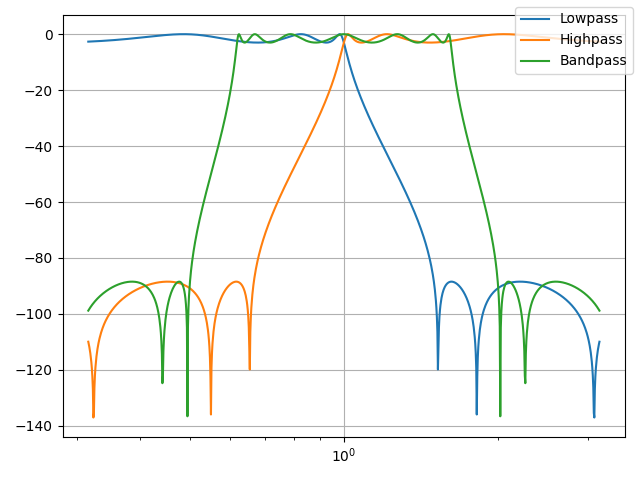

In [14]:
z,p,k = sp.signal.ellipap(N = 7, rp = 10*np.log10(2), rs = rs)
def task6_1():    
    freqs = np.logspace(-0.5, 0.5, 1001)
    
    w1, h1 = sp.signal.freqs_zpk(z, p, k , worN = freqs)
    w2, h2 = sp.signal.freqs_zpk(*sp.signal.lp2hp_zpk(z, p, k), worN = freqs)
    w3, h3 = sp.signal.freqs_zpk(*sp.signal.lp2bp_zpk(z, p, k), worN = freqs)
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.semilogx(w1, 20*np.log10(np.abs(h1)), label = "Lowpass")
    ax.semilogx(w2, 20*np.log10(np.abs(h2)), label = "Highpass")
    ax.semilogx(w3, 20*np.log10(np.abs(h3)), label = "Bandpass")
    fig.legend()
    fig.tight_layout()
    @interact(
        l0 = widgets.Checkbox(value = True, description = str(ax.lines[0])),
        l1 = widgets.Checkbox(value = True, description = str(ax.lines[1])),
        l2 = widgets.Checkbox(value = True, description = str(ax.lines[2])))
    def update(l0, l1, l2):
        ax.lines[0].set_ls("-" if l0 else "None")
        ax.lines[1].set_ls("-" if l1 else "None")
        ax.lines[2].set_ls("-" if l2 else "None")
task6_1()
print(f"Zeros = {z}")
print(f"Poles = {p}")

<IPython.core.display.Latex object>

,Q (inv. bandwidth),Qmax (poles)
0,2,196
1,5,478
2,10,952


interactive(children=(Checkbox(value=True, description='Line2D(Bandpass Q = 2)'), Checkbox(value=True, descrip…

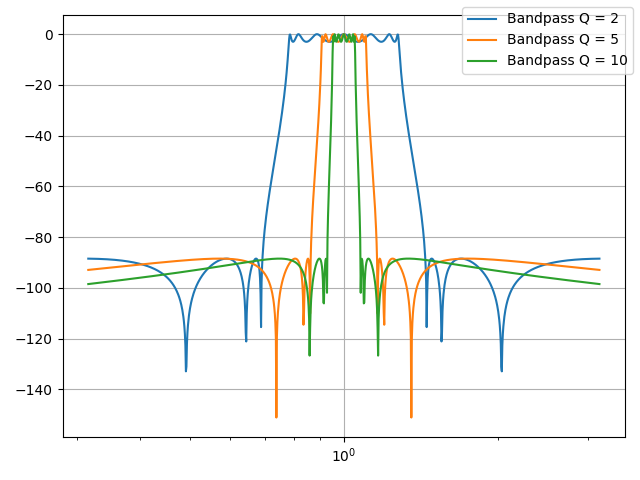

In [16]:
def task6_2():
    display(Latex("Измеряем добротности полюсов при разных значениях полос:"))
    freqs = np.logspace(-0.5, 0.5, 1001)
    
    fig, ax = plt.subplots()
    ax.grid(True)
    
    result = []
    traces = []
    for q in [2, 5, 10]:
        bw = 1/q
        z1, p1, k1 = sp.signal.lp2bp_zpk(z, p, k, bw = bw)
        Qmax = np.max(-np.abs(p1)/np.real(p1))
        result.append([q, Qmax])
        w, h = sp.signal.freqs_zpk(z1, p1, k1 , worN = freqs)
        ax.semilogx(w, 20*np.log10(np.abs(h)), label = f"Bandpass Q = {q}")
    fig.legend()
    fig.tight_layout()
    df = pd.DataFrame(result, columns=["Q (inv. bandwidth)", "Qmax (poles)"])
    display(df.style.format(precision = 0))
    @interact(
        l0 = widgets.Checkbox(value = True, description = str(ax.lines[0])),
        l1 = widgets.Checkbox(value = True, description = str(ax.lines[1])),
        l2 = widgets.Checkbox(value = True, description = str(ax.lines[2])))
    def update(l0, l1, l2):
        ax.lines[0].set_ls("-" if l0 else "None")
        ax.lines[1].set_ls("-" if l1 else "None")
        ax.lines[2].set_ls("-" if l2 else "None")

task6_2()

## 7. Полосовые фильтры радиоприемников

Селективность эллиптического фильтра 7-го порядка с ослаблением 80 дБ в полосе подавления:

In [17]:
eta = ellip_stopband_freq(7, 80)
display(Math(f"\eta = {eta:4.2f}"))

<IPython.core.display.Math object>

Оценим порядок фильтра Чебышева для достижения той же селективности:

In [18]:
result = []
for N in range(5, 15):
    w, h = sp.signal.freqs_zpk(*sp.signal.cheb1ap(N, rp = 10*np.log10(2)), worN = eta)
    result.append([N, -20*np.log10(np.abs(h[0]))])
df = pd.DataFrame(result, columns = ["Order", "Fade Level [dB]"])
display(df.style.format(precision = 1))

,Order,Fade Level [dB]
0,5,29.8
1,6,37.0
2,7,44.2
3,8,51.3
4,9,58.5
5,10,65.7
6,11,72.8
7,12,80.0
8,13,87.2
9,14,94.3


По таблице определяем $N_{cheby} = 12$

Определим максимальные добротности полюсов полосовых фильтров. 

Для фильтра Чебышева:

In [19]:
z,p,k = sp.signal.lp2bp_zpk(*sp.signal.cheb1ap(N = 12, rp = 10*np.log10(2)), bw = 1/20)
ChebyshevQmax = np.max(-np.abs(p)/np.real(p))
print(f"Qmax = {ChebyshevQmax:4.0f}")

Qmax = 4170


Для эллиптического фильтра:

In [20]:
z, p, k = sp.signal.lp2bp_zpk(*sp.signal.ellipap(N = 7, rp = 10*np.log10(2), rs = 80), bw = 1/20)
EllipQmax = np.max(-np.abs(p)/np.real(p))
print(f"Qmax = {EllipQmax:4.0f}")

Qmax = 2099
